In [105]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import pandas as pd
from dataclasses import dataclass
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
import eli5
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

import numpy as np
import itertools


In [106]:

df = pd.DataFrame.dropna(pd.read_csv('../annotations/annotated_.csv'))
text = df['textlabel']
labels = df['sentiment']

In [107]:
{"Rows": len(df), "Balance": round(df['sentiment'].value_counts(normalize=True), 2)}

{'Rows': 314,
 'Balance': sentiment
 irrelevant    0.64
 relevant      0.36
 Name: proportion, dtype: float64}

Encode the data labels

In [108]:
label_encoder = LabelEncoder()
labels_enc = label_encoder.fit_transform(labels)

Split into training and testing data

In [109]:
X_train, X_test, y_train, y_test = train_test_split(text, labels_enc, test_size=0.20)
print("Train:", np.unique(y_train, return_counts=True), "Test:", np.unique(y_test, return_counts=True)) 

Train: (array([0, 1]), array([164,  87])) Test: (array([0, 1]), array([37, 26]))


Create the pipelines for comparison.

In [110]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
pipelines = []
models = [LogisticRegression(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier()]
vectorizers = [ CountVectorizer(lowercase=True,stop_words=stopwords, ngram_range=(1,2)), TfidfVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(1,2))]

for model, vectorizer in itertools.product(models, vectorizers):
    pipeline = Pipeline([(vectorizer.__class__.__name__, vectorizer), (model.__class__.__name__, model)])
    pipelines.append({
        "combination_name": pipeline.steps[1][0] + ' ' + pipeline.steps[0][0], 
        "vectorizer": pipeline.steps[0][0],
        "model": pipeline.steps[1][0],
        "pipeline": pipeline,
        })

Our data is imbalanced and we prioritise relevant articles since it's better that irrelevant articles are mislabelled than missing out on relevant information.

In [123]:
stats = []
for model in pipelines:
    cross_val = cross_val_score(model['pipeline'],X_train, y_train, scoring="f1_macro", cv=10)
    mean, std = cross_val.mean(), cross_val.std()
    stats.append(pd.DataFrame({"mean": mean, "variance": std}, index=[model['combination_name']]))    


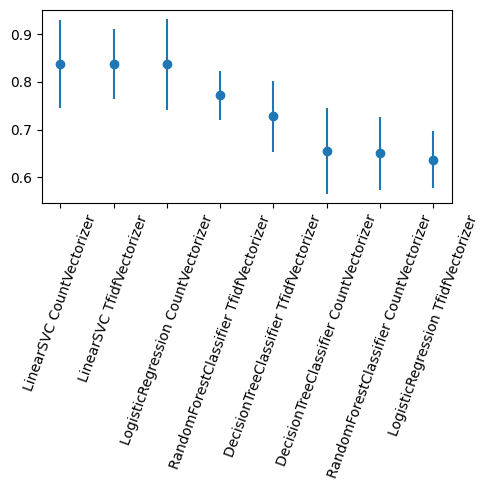

In [127]:
stats_df = pd.concat(stats)
stats_df = stats_df.sort_values(by=stats_df.columns.to_list(), ascending=False)
fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
ax.errorbar(stats_df.index, stats_df['mean'], stats_df['variance'], linestyle='None', marker='o')
ax.tick_params(axis='x', rotation=70)

In [128]:
stats_df

,mean,variance
LinearSVC CountVectorizer,0.837765,0.091959
LinearSVC TfidfVectorizer,0.837414,0.073756
LogisticRegression CountVectorizer,0.837311,0.095080
RandomForestClassifier TfidfVectorizer,0.772242,0.051329
DecisionTreeClassifier TfidfVectorizer,0.728118,0.074307
DecisionTreeClassifier CountVectorizer,0.655052,0.090479
RandomForestClassifier CountVectorizer,0.650617,0.077012
LogisticRegression TfidfVectorizer,0.636995,0.059835


In [120]:
stats2 = []
for model in pipelines:
    scores = cross_validate(model['pipeline'],X_train, y_train, scoring=["precision", "recall", "f1", "accuracy"])
    summary = {
        "accuracy_avg": np.mean(scores["test_accuracy"]),
        "f1_avg": np.mean(scores["test_f1"]),
        "precision_avg": np.mean(scores["test_precision"]),
        "recall_avg": np.mean(scores["test_recall"]),
    }

    stats2.append(pd.DataFrame(summary, index=[model['combination_name']]))    

stats_df2 = pd.concat(stats2)

We're looking for highest recall with good f1 and precision:

In [121]:
stats_df2['mean'] = stats_df2.mean(axis=1)
stats_df2.sort_values(by='mean', ascending=False)

,accuracy_avg,f1_avg,precision_avg,recall_avg,mean
LinearSVC TfidfVectorizer,0.864471,0.783190,0.860394,0.724837,0.808223
LinearSVC CountVectorizer,0.836314,0.759978,0.765175,0.758824,0.780073
LogisticRegression CountVectorizer,0.836392,0.732909,0.815359,0.677124,0.765446
RandomForestClassifier TfidfVectorizer,0.788784,0.627371,0.807042,0.516993,0.685048
DecisionTreeClassifier TfidfVectorizer,0.733176,0.645098,0.607507,0.703268,0.672262
DecisionTreeClassifier CountVectorizer,0.721255,0.605848,0.626935,0.630065,0.646026
RandomForestClassifier CountVectorizer,0.756941,0.501059,0.852778,0.357516,0.617074
LogisticRegression TfidfVectorizer,0.737176,0.407826,0.920000,0.265359,0.582591


In [158]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

best_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(1,2))),
    ("classifier", LinearSVC())
])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87        37
           1       0.94      0.62      0.74        26

    accuracy                           0.83        63
   macro avg       0.86      0.79      0.81        63
weighted avg       0.85      0.83      0.82        63



In [130]:
df_all = pd.read_json('../output/aljazeera_data.jsonl', lines=True)
df_all['prediction'] = best_pipeline.predict(df_all['content'])
df_all.to_csv('../output/relevant_articles.csv')


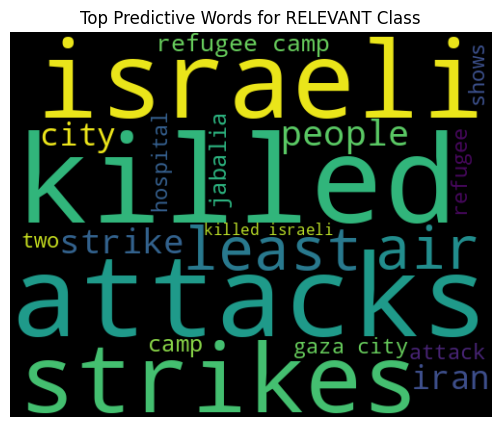

In [168]:
import eli5._feature_weights

vectorizer = best_pipeline.named_steps['vectorizer']
classifier = best_pipeline.named_steps['classifier']

# Get feature names and classifier weights
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # for binary classification


# Combine into a DataFrame
feature_importance = pd.DataFrame({
    'word': feature_names,
    'coef': coefficients
})





# Sort by relevance
top_relevant = feature_importance.sort_values(by='coef', ascending=False).head(20)
top_irrelevant = feature_importance.sort_values(by='coef')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_weights = dict(zip(top_relevant['word'], top_relevant['coef']))
wordcloud = WordCloud(width=500, height=400).generate_from_frequencies(word_weights)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Predictive Words for RELEVANT Class')
plt.show()


TFIDF gets a slightly lower score than bag of words because it downgrades frequent words like 'attack' whereas BOW takes the frequency of the words. What's interesting is how much more stable TFIDF is than BOW.